In [12]:
import pandas as pd
import pymongo
import requests
from bs4 import BeautifulSoup
import time
import json
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

from pandas.plotting import scatter_matrix

In [94]:
df.head()

,@id,_id,avatar,chess960_daily,chess_blitz,chess_bullet,chess_daily,chess_rapid,country,followers,games,joined,last_online,location,name,player_id,status,url,username
0,https://api.chess.com/pub/player/babu500,5afa039f098388ad5ff6a3a1,NaN,NaN,"{'last': {'rating': 777, 'date': 1525820389, '...",NaN,"{'last': {'rating': 1200, 'date': 1516320601, ...","{'last': {'rating': 974, 'date': 1522794278, '...",https://api.chess.com/pub/country/US,1,[[{'games': [{'url': 'https://www.chess.com/li...,1516059527,1526310229,NaN,NaN,42361082,premium,https://www.chess.com/member/babu500,babu500
1,https://api.chess.com/pub/player/0rlandomagic,5afa05ce098388c83c3f08fa,NaN,"{'last': {'rating': 1257, 'date': 1526259679, ...","{'last': {'rating': 1800, 'date': 1526089345, ...","{'last': {'rating': 2117, 'date': 1526323151, ...","{'last': {'rating': 1425, 'date': 1525869836, ...",NaN,https://api.chess.com/pub/country/US,13,[[{'games': [{'url': 'https://www.chess.com/da...,1515424234,1526322679,NaN,NaN,42121838,basic,https://www.chess.com/member/0rlandoMagic,0rlandomagic
2,https://api.chess.com/pub/player/0ldtower,5afa063e098388c83c3f08fc,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/country/US,0,"[[{'games': []}], [{'games': []}], [{'games': ...",1515958780,1526117639,NaN,Nick Chamberlain,42324950,basic,https://www.chess.com/member/0ldTower,0ldtower
3,https://api.chess.com/pub/player/0xvyper,5afa0641098388c83c3f08fe,NaN,NaN,"{'last': {'rating': 705, 'date': 1526217305, '...",NaN,NaN,"{'last': {'rating': 870, 'date': 1516238541, '...",https://api.chess.com/pub/country/US,1,[[{'games': [{'url': 'https://www.chess.com/li...,1515610811,1526216631,NaN,Vyper Dev,42192576,basic,https://www.chess.com/member/0xVyper,0xvyper
4,https://api.chess.com/pub/player/101arrowz,5afa0642098388c83c3f08ff,https://images.chesscomfiles.com/uploads/v1/us...,NaN,"{'last': {'rating': 851, 'date': 1526169302, '...","{'last': {'rating': 1183, 'date': 1525929576, ...","{'last': {'rating': 862, 'date': 1516843804, '...","{'last': {'rating': 828, 'date': 1518305784, '...",https://api.chess.com/pub/country/US,4,[[{'games': [{'url': 'https://www.chess.com/li...,1515980222,1526309228,NaN,NaN,42332948,basic,https://www.chess.com/member/101arrowz,101arrowz


In [101]:
def is_in_fist_30_days(df, player, month, game):
    month_from_date_joined = df['joined'][player] + 2629743
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return month_from_date_joined > time_of_game

is_in_fist_30_days(df, 0, 4, 0)

False

In [54]:
def games_in_a_month(df, player, month):
    return len(df['games'][player][month][0]['games'])

def is_in_fist_30_days(df, player, month, game):
    '''returns True if game was played within the first 30 days of signing up'''
    month_from_date_joined = df['joined'][player] + 2629743
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return month_from_date_joined > time_of_game


def games_in_first_month(df, player, month):
    '''returns a count of how many games were played by a user in the first 30 days since signing up'''
    games = 0
    if is_in_fist_30_days(df, player, month):
        games += 1
    return games


def rated_games(df, player, month, game):
    '''returns True if game was rated and it was played within the first 30 days of signing up'''
    if is_in_fist_30_days(df, player, month):
        return str(df['games'][month][0]['games'][game]['rated'])
    
def time_class_games(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month):
        return df['games'][player][month][0]['games'][game]['time_class']

def rules_games(df, player, month, game):
    if is_in_fist_30_days(df, player, month):
        return df['games'][player][month][0]['games'][game]['rules']
    
def eco_games(df, player, month, game):
    '''returns the eco code for opening played if the game was played in the first 30 days'''
    if is_in_fist_30_days(df, player, month):
        return df['games'][player][month][0]['games'][game]['eco'][31:].split('-')[0]

def results_games(df, player, month, game):
    '''returns the result of the each game played'''
    if is_in_fist_30_days(df, player, month):
        if df['games'][player][month][0]['games'][game]['white'] == df['username'][0]:
            return df['games'][player][month][0]['games'][game]['white']['result']
        else:
            return df['games'][player][month][0]['games'][game]['black']['result']

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, column='games', verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        column: column containing games, default column name is 'games'
        verbose: if True, print player indices as they are parsed, default is False
    '''
    player_idx = range(df.shape[0])
    for player in player_idx:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        for month in range(12):
            try:
                for game in range(games_in_a_month(df, player, month)):
                    try:
                        rated.append(rated_games(df, player, month, game))
                    except KeyError:
                        continue
                    try:
                        time_class.append(time_class_games(df, player, month, game))
                    except KeyError:
                        continue
                    try:
                        rules.append(rules_games(df, player, month, game))
                    except KeyError:
                        continue
#                         try:
#                             eco.append(eco_games(df, player, month, game))
#                         except KeyError:
#                             continue
                    try:
                        results.append(results_games(df, player, month, game))
                    except KeyError:
                        continue
                    try:
                        df.loc[player, 'january_games'] = games_in_a_month(df, player, 0)
                    except KeyError:
                        df.loc[player, 'january_games'] = 0
            except KeyError:
                continue


        df.loc[player, 'may_games'] = games_in_a_month(df, player, 4)
        try:
            df.loc[player, 'january_games'] = games_in_a_month(df, player, 0)
        except KeyError:
            df.loc[player, 'january_games'] = 0

        make_columns(time_class, df, player)
        make_columns(rated, df, player)
        make_columns(rules, df, player)
#             make_columns(eco, df, player)
        make_columns(results, df, player)
            
def init_columns(df):
    '''Add columns for all eco codes, rated games, time_class, rules
    Params:
        df: pandas dataframe
    '''
    labels = ['win', 'checkmated', 'agreed', 'repetition', 'timeout', 'resigned', 
              'stalemate', 'lose', 'insufficient', '50move', 'abandoned', 'kingofthehill',
              'threecheck', 'timevsinsufficient', 'bughousepartnerlose', 'False', 'True',
              'standard', 'daily', 'blitz', 'lightning', 'chess960', 'crazyhouse', 'bughouse', 'chess']
    for label in labels:
        df[label] = 0
        
def add_features(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        df: dataframe with all feature columns and target column
    '''
    #initialize columns
    init_columns(df)

    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in two weeks (may 1st)
    def is_inactive(x):
        '''checks if value is less than 2
        '''
        if x < :
            return 1
        else:
            return 0

    df['inactive'] = df['may_games'].apply(lambda x: is_inactive(x))

    #create columns has_name, has_location, has_avatar
    def has_attribute(x):
        if x != x:
            return 0
        else:
            return 1

    df['has_name'] = df['name'].apply(lambda x: has_attribute(x))
    df['has_location'] = df['location'].apply(lambda x: has_attribute(x))
    df['has_avatar'] = df['avatar'].apply(lambda x: has_attribute(x))

    #make a basic account type column
    def is_basic(x):
        '''check if value is the string basic'''
        if x == 'basic':
            return 1
        else:
            return 0

    df['is_basic'] = df['status'].apply(lambda x: is_basic(x))

    #make a premium account type column
    def is_premium(x):
        '''check if value is the string premium'''
        if x == 'premium':
            return 1
        else:
            return 0

    df['is_premium'] = df['status'].apply(lambda x: is_premium(x))
    
    df.drop(columns=['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz',
                         'chess_bullet', 'chess_daily', 'chess_rapid', 'country',
                         'games', 'last_online', 'location', 'name', 'player_id',
                         'status', 'url', 'username', 'may_games'], inplace=True) 
    return df
    
    
def make_X_y(df):
    '''returns:
        X: all important feature columns
        y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)'''
    #assign X and y variables
    y = df['inactive']
    
    X = df.drop(columns=['inactive'])
    
    return (X, y)

In [93]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

print('import data from mongoDB to pandas dataframe')
#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players'].find()))

print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

# print('now making features and target')

# # make features and target
# add_features(df)

# #create features and target dataframes
# X, y = make_X_y(df)

# #make a train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


# random_forest_testrun = RandomForestClassifier()
# random_forest_testrun.fit(X_train, y_train)
# y_predict = random_forest_testrun.predict_proba(X_test)

# print(roc_auc_score(y_test, y_predict[:, 1]))

import data from mongoDB to pandas dataframe
done importing from mongoDB


In [89]:
# #create features and target dataframes
# X, y = make_X_y(df.fillna(0))

# #make a train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train[['january_games', 'is_basic','has_location', 'has_avatar']], y_train)
y_predict = random_forest_testrun.predict_proba(X_test[['january_games', 'is_basic','has_location', 'has_avatar']])

print(roc_auc_score(y_test, y_predict[:, 1]))

print(cross_val_score(random_forest_testrun, X_test[['january_games', 'is_basic','has_location', 'has_avatar']], y_test, cv=20))

0.7667652859960552
[0.78947368 0.84210526 0.63157895 0.68421053 0.89473684 0.94736842
 0.77777778 0.72222222 0.77777778 0.83333333 0.77777778 0.88888889
 0.61111111 0.77777778 0.72222222 0.77777778 0.83333333 0.61111111
 0.82352941 0.64705882]


In [45]:
df.fillna(0)

,followers,joined,win,checkmated,agreed,repetition,timeout,resigned,stalemate,lose,...,january_games,february_games,march_games,april_games,inactive,has_name,has_location,has_avatar,is_basic,is_premium
0,1,1516059527,19,6,0,0,3,5,0,0,...,10.0,0.0,0.0,23.0,0,0,0,0,0,1
1,13,1515424234,800,200,2,3,372,233,7,0,...,29.0,410.0,575.0,639.0,0,0,0,0,1,0
2,0,1515958780,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,1,0,0,1,0
3,1,1515610811,3,0,0,0,0,3,0,0,...,6.0,0.0,0.0,0.0,0,1,0,0,1,0
4,4,1515980222,181,77,9,3,26,74,3,0,...,16.0,80.0,242.0,61.0,0,0,0,1,1,0
5,3,1517119305,460,137,0,6,118,166,11,0,...,29.0,447.0,266.0,205.0,0,0,0,0,1,0
6,1,1515536249,671,194,1,1,456,67,2,0,...,240.0,462.0,380.0,331.0,0,1,0,1,1,0
7,0,1516522024,170,35,0,0,72,76,2,0,...,0.0,0.0,166.0,198.0,0,1,0,1,1,0
8,12,1517288444,140,61,0,0,37,48,5,0,...,3.0,10.0,95.0,193.0,0,1,0,1,1,0
9,2,1516237039,2,1,0,0,3,0,0,0,...,0.0,6.0,0.0,0.0,0,1,0,0,1,0


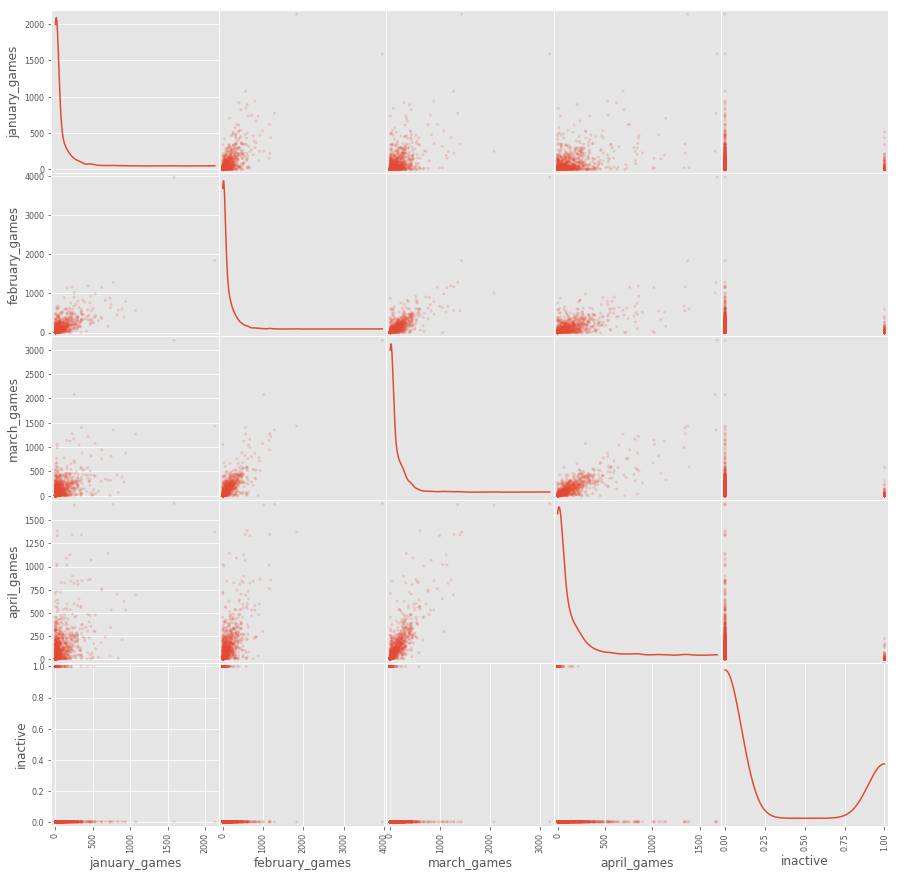

In [43]:
scatter_matrix(df[['january_games', 'february_games', 'march_games', 'april_games', 'inactive']], alpha=0.2, figsize=(15, 15), diagonal='kde');

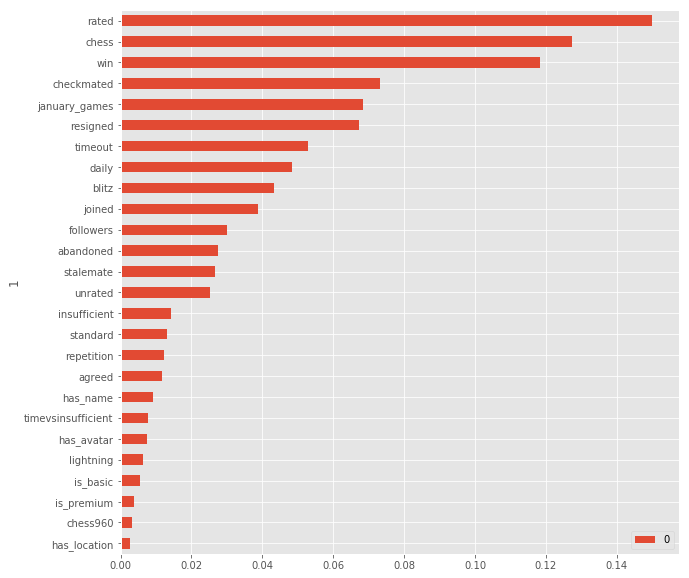

In [57]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

values, features = rf_best_features(X_test, y_test, 26)
plot_best_features(values, features)

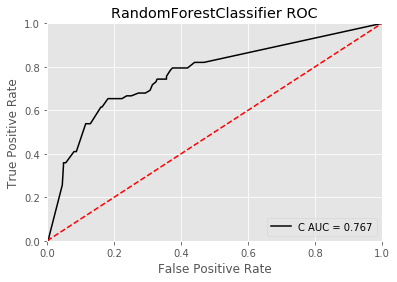

In [90]:
def plot_roc(model, x_columns, y_true):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_roc(random_forest_testrun, X_test[['january_games', 'is_basic','has_location', 'has_avatar']], y_test)